In [161]:
import pandas as pd
from tqdm import tqdm

In [2]:
from sqlalchemy import create_engine, MetaData, Table, Column, Integer, String, select, Float, and_, or_
from dotenv import load_dotenv
import os

In [3]:
load_dotenv()

DB_PASS = os.getenv("DB_PASS")
DB_USER = os.getenv("DB_USER")
DB_HOST = os.getenv("DB_HOST")

engine = create_engine(f"mysql://{DB_USER}:{DB_PASS}@{DB_HOST}/options")

In [190]:
options = pd.read_sql('options_data', engine)

In [191]:
options['date'] = options['pull_timestamp'].apply(lambda x: x.date())

In [192]:
options['date']

0        2020-12-18
1        2020-12-18
2        2020-12-18
3        2020-12-18
4        2020-12-18
            ...    
51368    2021-01-07
51369    2021-01-07
51370    2021-01-07
51371    2021-01-07
51372    2021-01-07
Name: date, Length: 51373, dtype: object

In [193]:
expiration_prices = options[(options['days_to_expiry'] == 0)][['expiry', 'ticka', 'close_on_pull', 'strike', 'contract', 'contract_name']].copy()

In [194]:
expiration_prices

,expiry,ticka,close_on_pull,strike,contract,contract_name
0,2020-12-18,SHOP,1170.96,860.0,P,SHOP201218P00860000
1,2020-12-18,SHOP,1170.96,865.0,P,SHOP201218P00865000
2,2020-12-18,SHOP,1170.96,875.0,P,SHOP201218P00875000
3,2020-12-18,SHOP,1170.96,880.0,P,SHOP201218P00880000
4,2020-12-18,SHOP,1170.96,890.0,P,SHOP201218P00890000
...,...,...,...,...,...,...
39420,2020-12-31,ADBE,500.12,590.0,C,ADBE201231C00590000
39421,2020-12-31,ADBE,500.12,600.0,C,ADBE201231C00600000
39422,2020-12-31,ADBE,500.12,610.0,C,ADBE201231C00610000
39423,2020-12-31,ADBE,500.12,620.0,C,ADBE201231C00620000


In [195]:
def assignement(row):
    if row['contract'] == 'P':
        if row['strike'] > row['close_on_pull']:
            return 1
        else:
            return 0
    if row['contract'] == 'C':
        if row['strike'] < row['close_on_pull']:
            return 1
        else:
            return 0
    #otherwise
    return -1

expiration_prices['assigned'] = expiration_prices.apply(assignement, axis = 1)

In [196]:
expiration_prices

,expiry,ticka,close_on_pull,strike,contract,contract_name,assigned
0,2020-12-18,SHOP,1170.96,860.0,P,SHOP201218P00860000,0
1,2020-12-18,SHOP,1170.96,865.0,P,SHOP201218P00865000,0
2,2020-12-18,SHOP,1170.96,875.0,P,SHOP201218P00875000,0
3,2020-12-18,SHOP,1170.96,880.0,P,SHOP201218P00880000,0
4,2020-12-18,SHOP,1170.96,890.0,P,SHOP201218P00890000,0
...,...,...,...,...,...,...,...
39420,2020-12-31,ADBE,500.12,590.0,C,ADBE201231C00590000,0
39421,2020-12-31,ADBE,500.12,600.0,C,ADBE201231C00600000,0
39422,2020-12-31,ADBE,500.12,610.0,C,ADBE201231C00610000,0
39423,2020-12-31,ADBE,500.12,620.0,C,ADBE201231C00620000,0


In [197]:
bands = pd.read_sql('band_data', engine)

In [198]:
bands.rename(columns={'ticker':'ticka'}, inplace=True)

In [199]:
bands['date'] = bands['date'].apply(lambda x: x.date())

In [200]:
bands

,date,adjclose,ticka,MA,STD,Upper,Lower
0,2020-09-14,931.830,SHOP,1019.8500,56.81620,1133.4800,906.2170
1,2020-09-15,929.390,SHOP,1014.7300,57.83920,1130.4100,899.0490
2,2020-09-16,885.180,SHOP,1008.2300,61.10270,1130.4400,886.0280
3,2020-09-17,870.760,SHOP,1000.7700,63.79730,1128.3600,873.1760
4,2020-09-18,901.340,SHOP,994.5440,64.09170,1122.7300,866.3610
...,...,...,...,...,...,...,...
14990,2020-12-28,29.005,PLAY,26.0552,1.81870,29.6926,22.4178
14991,2020-12-29,29.540,PLAY,26.3115,1.74605,29.8036,22.8194
14992,2020-12-30,28.840,PLAY,26.4795,1.73852,29.9565,23.0025
14993,2020-12-31,30.020,PLAY,26.6722,1.80093,30.2740,23.0703


In [201]:
options = options.merge(bands.drop(columns=['adjclose']), on=['date','ticka'])

In [202]:
options

,contract_name,last_trade_date,strike,last_price,bid,ask,change,pct_change,volume,open_interest,...,pull_timestamp,expiry,days_to_expiry,close_on_pull,ticka,date,MA,STD,Upper,Lower
0,SHOP201218P00860000,2020-12-18 10:04:00,860.0,0.03,0.00,0.05,-0.16,-0.8421,1,88,...,2020-12-18 16:15:25,2020-12-18,0,1170.96,SHOP,2020-12-18,1023.220,81.8621,1186.950,859.498
1,SHOP201218P00865000,2020-12-18 12:32:00,865.0,0.02,0.00,0.05,-0.03,-0.6000,1,107,...,2020-12-18 16:15:25,2020-12-18,0,1170.96,SHOP,2020-12-18,1023.220,81.8621,1186.950,859.498
2,SHOP201218P00875000,2020-12-18 15:37:00,875.0,0.01,0.00,0.05,-0.06,-0.8571,20,79,...,2020-12-18 16:15:25,2020-12-18,0,1170.96,SHOP,2020-12-18,1023.220,81.8621,1186.950,859.498
3,SHOP201218P00880000,2020-12-17 12:03:00,880.0,0.26,0.00,0.05,0.22,5.5000,4,115,...,2020-12-18 16:15:25,2020-12-18,0,1170.96,SHOP,2020-12-18,1023.220,81.8621,1186.950,859.498
4,SHOP201218P00890000,2020-12-18 11:20:00,890.0,0.01,0.50,0.05,-0.04,-0.8000,1,105,...,2020-12-18 16:15:25,2020-12-18,0,1170.96,SHOP,2020-12-18,1023.220,81.8621,1186.950,859.498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40276,ADBE210108C00590000,2020-12-21 09:44:00,590.0,0.34,0.00,0.13,0.00,0.0000,2,4,...,2021-01-04 16:17:28,2021-01-08,4,485.34,ADBE,2021-01-04,485.782,12.9130,511.608,459.956
40277,ADBE210108C00600000,2020-12-31 13:59:00,600.0,0.27,0.01,0.08,0.00,0.0000,6,61,...,2021-01-04 16:17:28,2021-01-08,4,485.34,ADBE,2021-01-04,485.782,12.9130,511.608,459.956
40278,ADBE210108C00610000,2020-12-31 13:59:00,610.0,0.26,0.00,0.10,0.00,0.0000,2,1,...,2021-01-04 16:17:28,2021-01-08,4,485.34,ADBE,2021-01-04,485.782,12.9130,511.608,459.956
40279,ADBE210108C00620000,2020-12-28 11:08:00,620.0,0.10,0.00,0.14,0.00,0.0000,1,2,...,2021-01-04 16:17:28,2021-01-08,4,485.34,ADBE,2021-01-04,485.782,12.9130,511.608,459.956


In [203]:
options['assigned'] = -1

In [204]:
for index, row in tqdm(expiration_prices.iterrows()):
    assignment = row['assigned']
    options['assigned'] = options['assigned'].where(options['contract_name'] != row['contract_name'], assignment)

9155it [00:18, 502.94it/s]


In [205]:
options = options[options['assigned'] != -1].copy()

In [206]:
options['SD_to_MA'] = options['STD']/options['MA']
options['pct_MA_to_adj'] = ((options['close_on_pull']/options['MA'])-1)
options['pct_adj_to_strike'] = ((options['strike']/options['close_on_pull'])-1)

In [207]:
options.to_csv('two_months_options.csv', index=False)

In [208]:
options.columns

Index(['contract_name', 'last_trade_date', 'strike', 'last_price', 'bid',
       'ask', 'change', 'pct_change', 'volume', 'open_interest',
       'implied_volatility', 'contract', 'pull_timestamp', 'expiry',
       'days_to_expiry', 'close_on_pull', 'ticka', 'date', 'MA', 'STD',
       'Upper', 'Lower', 'assigned', 'SD_to_MA', 'pct_MA_to_adj',
       'pct_adj_to_strike'],
      dtype='object')

In [209]:
options[options['assigned'] == 1]

,contract_name,last_trade_date,strike,last_price,bid,ask,change,pct_change,volume,open_interest,...,ticka,date,MA,STD,Upper,Lower,assigned,SD_to_MA,pct_MA_to_adj,pct_adj_to_strike
54,SHOP201218P01175000,2020-12-18 15:58:00,1175.0,3.07,1.80,5.00,-5.93,-0.6589,135,2,...,SHOP,2020-12-18,1023.220,81.8621,1186.950,859.498,1,0.080004,0.144387,0.003450
55,SHOP201218P01180000,2020-12-18 15:57:00,1180.0,7.80,4.90,9.40,-3.20,-0.2909,134,2,...,SHOP,2020-12-18,1023.220,81.8621,1186.950,859.498,1,0.080004,0.144387,0.007720
56,SHOP201218P01185000,2020-12-18 15:56:00,1185.0,10.70,9.50,16.10,-3.80,-0.2621,52,1,...,SHOP,2020-12-18,1023.220,81.8621,1186.950,859.498,1,0.080004,0.144387,0.011990
57,SHOP201218P01190000,2020-12-18 15:45:00,1190.0,23.00,13.80,19.20,6.70,0.4110,162,2,...,SHOP,2020-12-18,1023.220,81.8621,1186.950,859.498,1,0.080004,0.144387,0.016260
58,SHOP201218P01195000,2020-12-18 15:54:00,1195.0,23.77,20.00,25.50,2.27,0.1056,118,2,...,SHOP,2020-12-18,1023.220,81.8621,1186.950,859.498,1,0.080004,0.144387,0.020530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37701,ADBE201231C00487500,2020-12-30 15:09:00,487.5,8.64,8.55,12.80,-2.01,-0.1887,5,46,...,ADBE,2020-12-31,484.922,13.7784,512.479,457.365,1,0.028414,0.031341,-0.025234
37702,ADBE201231C00490000,2020-12-31 15:05:00,490.0,8.04,10.10,11.60,0.43,0.0565,75,196,...,ADBE,2020-12-31,484.922,13.7784,512.479,457.365,1,0.028414,0.031341,-0.020235
37703,ADBE201231C00492500,2020-12-31 13:29:00,492.5,3.94,3.35,8.65,-2.99,-0.4315,23,47,...,ADBE,2020-12-31,484.922,13.7784,512.479,457.365,1,0.028414,0.031341,-0.015236
37704,ADBE201231C00495000,2020-12-31 15:46:00,495.0,3.59,4.75,5.25,-0.32,-0.0818,229,196,...,ADBE,2020-12-31,484.922,13.7784,512.479,457.365,1,0.028414,0.031341,-0.010238


In [210]:
puts = options[options['contract'] == 'P'].copy()
calls = options[options['contract'] == 'C'].copy()

In [267]:
puts['Safe'] = puts['strike'] < puts['Lower']
puts['Safe'] = puts['Safe'].apply(lambda x: 1 if True else 0)
calls['Safe'] = calls['strike'] > calls['Upper']
calls['Safe'] = calls['Safe'].apply(lambda x: 1 if True else 0)

In [320]:
puts['fake_z'] = puts['MA']/puts['STD']
calls['fake_z'] = calls['MA']/calls['STD']

In [268]:
from sklearn.model_selection import train_test_split

In [269]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
def plot_metric(clf, testX, testY, name):
    """
    Small function to confusion matrix
    """
    plt.style.use('ggplot')
    plot_confusion_matrix(clf, testX, testY, normalize='true')
    plt.title(f"Confusion Matrix [{name}]")

In [316]:
p_trainX, p_validX, p_trainY, p_validY = train_test_split(puts[['implied_volatility', 'fake_z']], puts['assigned'], test_size=0.20, random_state=101)

In [317]:
from sklearn.ensemble import RandomForestClassifier
puts_rf_classifier = RandomForestClassifier()
puts_rf_classifier.fit(p_trainX, p_trainY)
print(f"Validation Accuracy of Random Forest Classifier is: {(puts_rf_classifier.score(p_validX, p_validY))*100:.2f}%")

Validation Accuracy of Random Forest Classifier is: 75.21%


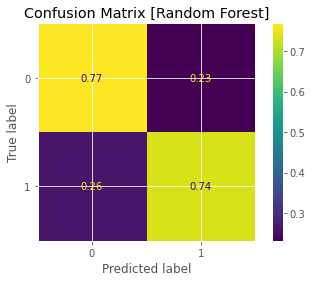

In [318]:
plot_metric(puts_rf_classifier, p_validX, p_validY, "Random Forest")

In [319]:
puts_rf_classifier.feature_importances_

array([0.6740872, 0.3259128])

In [321]:
c_trainX, c_validX, c_trainY, c_validY = train_test_split(calls[['implied_volatility', 'fake_z']], calls['assigned'], test_size=0.20, random_state=897)

In [322]:
from sklearn.ensemble import RandomForestClassifier
calls_rf_classifier = RandomForestClassifier()
calls_rf_classifier.fit(c_trainX, c_trainY)
print(f"Validation Accuracy of Random Forest Classifier is: {(calls_rf_classifier.score(c_validX, c_validY))*100:.2f}%")

Validation Accuracy of Random Forest Classifier is: 75.99%


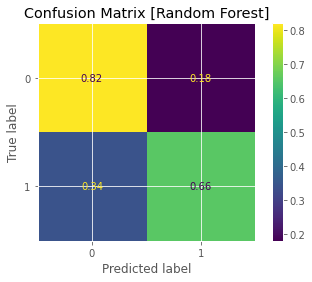

In [323]:
plot_metric(calls_rf_classifier, c_validX, c_validY, "Random Forest")

In [324]:
calls_rf_classifier.feature_importances_

array([0.59480801, 0.40519199])

In [239]:
puts['assigned'].sum()

8243